In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, regexp_replace, lower, explode, trim, split
from pyspark.sql.types import StructType, StructField, StringType
import matplotlib.pyplot as plt

In [1]:
# Pick your word:
word = "football"

In [23]:
# The code can currently not run with all years and months selected
years = ["06", "07", "08", "09", "10"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
#months = ["01"]

In [4]:
spark = SparkSession.builder\
    .master("spark://192.168.2.97:7077") \
    .appName("claude_carlsson_hdfs")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
    .config("spark.shuffle.service.enabled", True)\
    .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
    .config("spark.cores.max", 5)\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/13 07:35:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
def parse_json_body_to_string(json_filename):
    # Read the json file
    df = spark.read.json(json_filename)

    # Make everything lowercase
    my_df_lower = df.select(lower("body").alias("lowercase_body"))

    # Remove all charachters that exist in charachters_to_delete
    charachters_to_delete = "[\.,\[\]\(\):_\-!?\'\+=;/&{}@$#*\"\\\\%><|~¨´¤]"

    my_df_clean = my_df_lower.withColumn("lowercase_body", regexp_replace(my_df_lower.lowercase_body, charachters_to_delete, ""))

    # Parse the body to words
    my_df_words = my_df_clean.select(explode(split("lowercase_body", "\s+")).alias("word"))

    return my_df_words

In [24]:
def get_word_count():
    word_count = {}
    years = ["06", "07", "08", "09", "10"]
    #months = ["01"]
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    empty_schema = StructType([StructField("word", StringType(), True),])

    for year in years:
        df_this_year = spark.createDataFrame([], empty_schema)

        # Append all the months to the dataframe
        for month in months:
            df_month = parse_json_body_to_string("hdfs://192.168.2.97:50000/user/ubuntu/RC_20" + year + "-" + month + ".json")
            df_this_year = df_this_year.union(df_month)

        # Count and sort the words. Save the result in word_count
        word_count_this_year = df_this_year.groupBy("word").count().orderBy("count", ascending=False)
        year_string = "20" + year
        word_count.update({year_string: word_count_this_year})
        
    return word_count

In [7]:
import pyspark.sql.functions as ps_func

def word_use_by_year(word, years, word_count):
    word_count_by_year = []
    
    for year in years:
        word_count_filtered = word_count[year].filter(ps_func.col("word") == word)
        if word_count_filtered == "None":
            # If the filtered DataFrame is empty, set the count to zero
            word_count_sum = 0
        else:
            # If the filtered DataFrame is not empty, sum the counts of the matching rows
            word_count_sum = word_count_filtered.agg(ps_func.sum("count")).collect()[0][0]

        word_count_by_year.append(word_count_sum)
    return word_count_by_year

In [45]:
# Get word_count
word_count = get_word_count()

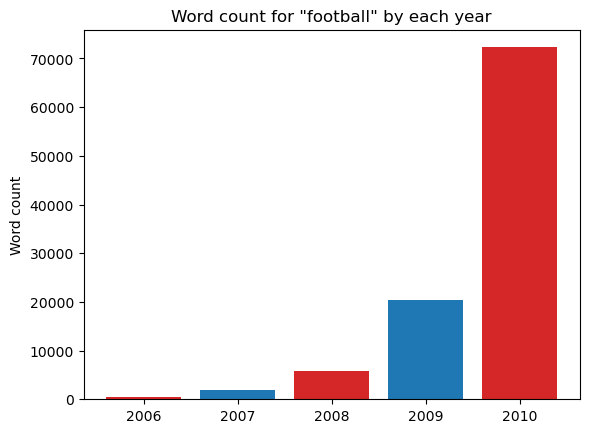

In [46]:
# Get all variables
word = word.lower()
years_available = list(word_count.keys())

# Get the results
word_count_per_year = word_use_by_year(word, years_available, word_count)

# Draw a plot with the results
_, ax = plt.subplots()
bar_colors = ['tab:red', 'tab:blue']
ax.bar(years_available, word_count_per_year, color=bar_colors)
ax.set_ylabel('Word count')
ax.set_title('Word count for "' + word + '" by each year')

plt.show()

In [47]:
spark.stop()